In [2]:
#basic imports ✌

import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

In [16]:
#creating the signals 👌

def sine(X,signal_freq=60.):
    return np.sin(2*np.pi*(X)/signal_freq)

def noisy(Y,noise_range=(-0.35,0.35)):
    noise=np.random.uniform(noise_range[0],noise_range[1],size=Y.shape)
    return Y+noise

def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

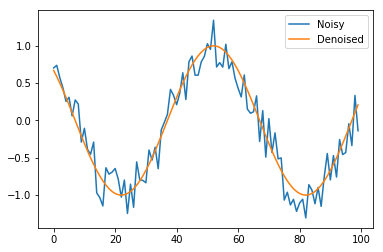

In [4]:
# generating figures 👍👍👍👍👍

inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()

In [5]:
#genereate dataset 👀👀👀

def create_dataset(n_samples=10000, sample_size=100):
    data_inp= np.zeros((n_samples,sample_size))
    data_out= np.zeros((n_samples,sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp,data_out

In [6]:
data_inp,data_out = create_dataset()
train_inp, train_out= data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [7]:
import torch 
import torch.nn as nn
from torch.autograd import Variable

In [10]:
#The RNN 👌👌👌👌👌

input_dim=1
hidden_size=30
num_layers=1

bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)


C:\apps\Miniconda\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [11]:
r

CustomRNN(
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [12]:
# TRAINING 💪💪💪💪💪💪💪💪💪💪💪

predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

C:\apps\Miniconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 tensor(0.5880)
20 tensor(0.1010)
40 tensor(0.0886)
60 tensor(0.0802)
80 tensor(0.0593)
100 tensor(0.0484)
120 tensor(0.0446)
140 tensor(0.0404)
160 tensor(0.0417)
180 tensor(0.0426)
200 tensor(0.0389)
220 tensor(0.0389)
240 tensor(0.0356)
260 tensor(0.0350)
280 tensor(0.0315)
300 tensor(0.0320)


In [13]:
#generating prediction on test set
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

tensor(0.0331)


C:\apps\Miniconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Text(0.5, 1.0, 'Sample num: 23')

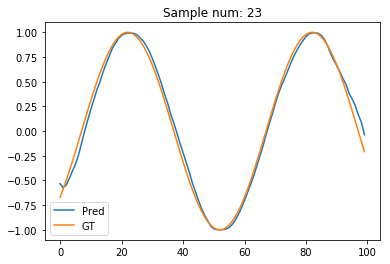

In [14]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))